# NURBS - Undulated Window

Author: Matteo Taccola

This example shows how to use the NURBS geometry explicitly defining the parameters that generate the NURBS (control points, weights etc).
Also more simple surface types are supported (Bezier, Rational Bezier, BSPLINE)  
For this specific example a glass window is simulated. Both sides of the window have the same NURBS surface profile.
This example has no practical applications. It is just to illustrate the use of the geometry

In [2]:
from optiland.geometries import NurbsGeometry

In [3]:
from optiland import analysis, optic, optimization
from optiland.coordinate_system import CoordinateSystem
from optiland.materials import IdealMaterial, Material
from optiland.surfaces import Surface
import optiland.backend as be

Define NURBS parameters.

In [ ]:
# Define the number of control points
n_dim, n, m = 3, 15, 15

# Aperture size
size_x=50
size_y=50

# Define control points
x = be.linspace(-size_x/2,size_x/2,n)
y = be.linspace(-size_y/2,size_y/2,m)
x,y = be.meshgrid(x,y)
z = 2.0*be.sin(x*2*be.pi*2/size_x+y*2*be.pi*2/size_y)

P = be.zeros((n_dim, n, m))
P[0,:,:] = x.T
P[1,:,:] = y.T
P[2,:,:] = z.T
    
# Define the array of control point weights
W = be.ones((n, m))

# Maximum index of the control points (counting from zero)
n = be.shape(P)[1] - 1
m = be.shape(P)[2] - 1

# Define the order of the basis polynomials
# Linear (p = 1), Quadratic (p = 2), Cubic (p = 3), etc.
# Set p = n (number of control points minus one) to obtain a Bezier
p = 3
q = 3

# Define the knot vectors (clamped spline)
# p+1 zeros, n-p equispaced points between 0 and 1, and p+1 ones.  In total r+1 points where r=n+p+1
# q+1 zeros, m-p equispaced points between 0 and 1, and q+1 ones. In total s+1 points where s=m+q+1
U = be.concatenate((be.zeros(p), be.linspace(0, 1, n - p + 2), be.ones(p)))
V = be.concatenate((be.zeros(q), be.linspace(0, 1, m - q + 2), be.ones(q)))

In [5]:
cs1 = CoordinateSystem(x=0, y=0, z=0, rx=0, ry=0, rz=0, reference_cs=None)
cs2 = CoordinateSystem(x=0, y=0, z=5, rx=0, ry=0, rz=0, reference_cs=None)

In [6]:
# if control points are passed radius and conic are ignored. The surface is built as NURBS from control points and weights 
nurbs_geo1 = NurbsGeometry(
    coordinate_system=cs1,
    radius = be.inf,
    conic=0.0,
    control_points=P, 
    weights=W, 
    u_degree=p, 
    v_degree=q, 
    u_knots=U, 
    v_knots=V
)        
nurbs_geo2 = NurbsGeometry(
    coordinate_system=cs2,
    radius = be.inf,
    conic=0.0,
    control_points=P, 
    weights=W, 
    u_degree=p, 
    v_degree=q, 
    u_knots=U, 
    v_knots=V
)        

In [7]:
air = IdealMaterial(n=1.0)  # air
glass = Material(name="SF2")

In [8]:
new_surface1 = Surface(
    geometry=nurbs_geo1,
    material_pre=air,
    material_post=glass,
    is_stop=True,
)
new_surface2 = Surface(
    geometry=nurbs_geo2,
    material_pre=glass,
    material_post=air,
)

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

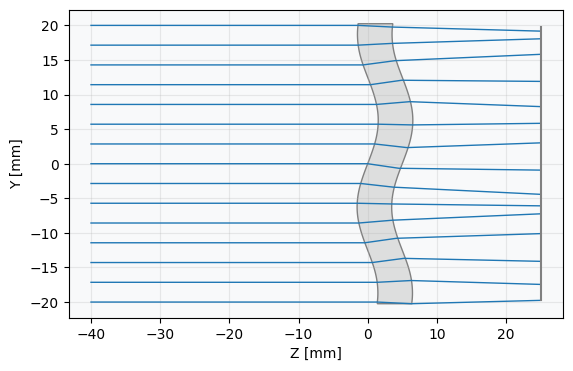

In [10]:
lens = optic.Optic()

# add surfaces
lens.add_surface(index=0, radius=be.inf, thickness=be.inf)
lens.add_surface(
    index=1,
    new_surface=new_surface1,
) 
lens.add_surface(
    index=2,
    new_surface=new_surface2,
    thickness=20,
) 

lens.add_surface(index=3)

# add aperture
lens.set_aperture(aperture_type="EPD", value=40)

# add field
lens.set_field_type(field_type="angle")
lens.add_field(y=0)

# add wavelength
lens.add_wavelength(value=0.55, is_primary=True)

lens.update_paraxial()
   
lens.draw(num_rays=15)